In [3]:
import pandas as pd
import vertica_python
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [4]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

# Queries
* * *
### Overall Completion Rate

In [5]:
#DROP TABLE IF EXISTS ahemphill.course_run_length;
#CREATE TABLE ahemphill.course_run_length AS#

#SELECT
#	a.course_id,
#	a.catalog_course_title,
#	a.level_type,
#	b.subject_title,
#	a.start_time,
#	a.end_time,
#	DATEDIFF(day, a.start_time, a.end_time) AS course_run_days
#FROM
#	production.d_course a
#LEFT JOIN
#	production.d_course_subjects b
#ON 
#	a.course_id = b.course_id
#WHERE
#	a.pacing_type = 'instructor_paced'
#	AND a.availability = 'Archived';#
#

#DROP TABLE IF EXISTS ahemphill.completion_rate_all;
#CREATE TABLE ahemphill.completion_rate_all AS
#	SELECT
#		a.user_id,
#		a.course_id,
#		a.current_enrollment_mode,
#		a.first_enrollment_mode,
#		a.first_enrollment_time,
#		b.catalog_course_title,
#		b.end_time AS end_time_from_d_course,
#		c.enddate AS end_time_ed_services_table,
#		d.certificate_mode,
#		d.has_passed
#	FROM
#		production.d_user_course a	
#	LEFT JOIN
#		production.d_course b
#	ON
#	       a.course_id = b.course_id
#	LEFT JOIN
#	       ed_services.CourseCatalog_20161010 c
#	ON
#	       a.course_id = c.CourseID
#	LEFT JOIN
#	    production.d_user_course_certificate d
#	ON     
#	    a.user_id = d.user_id
#	    AND a.course_id = d.course_id
#	WHERE
#		b.pacing_type = 'instructor_paced'
#		AND a.first_enrollment_time <= c.enddate
#		AND a.first_enrollment_time IS NOT NULL


In [10]:
completion_rate_query = """

SELECT
	course_id,
    user_age,
    user_last_location_country_code,
    user_gender,
    SUM(CASE WHEN has_passed IS NULL THEN NULL ELSE has_passed END) AS completion_count,
    COUNT(1) AS enroll_count
FROM 
    ahemphill.completion_rate_all
WHERE
    end_time_ed_services_table BETWEEN '2016-01-01' AND '2016-10-01'
GROUP BY 1,2,3,4
"""

In [11]:
connection = vertica_python.connect(**conn_info)
    
cur = connection.cursor('dict')
cur.execute(completion_rate_query)
extract = cur.fetchall()
completion_rate_df = pd.DataFrame(extract)


connection.close()

In [13]:
completion_rate_df.head()

,completion_count,course_id,enroll_count,user_age,user_gender,user_last_location_country_code
0,0.0,HarvardX/CS50x3/2015,2,55.0,m,MT
1,0.0,course-v1:MITx+8.05.3x+1T2016,1,20.0,m,TH
2,0.0,course-v1:W3Cx+HTML5.1x+2T2016,1,20.0,m,HT
3,NaN,course-v1:Microsoft+DAT208x+1T2016,2,26.0,f,TN
4,0.0,course-v1:BerkeleyX+CS169.2x+1T2016,1,23.0,m,AZ


In [22]:
age_agg_df = (completion_rate_df.groupby('user_age').sum()['completion_count']*100.0/completion_rate_df.groupby('user_age').sum()['enroll_count']).reset_index()

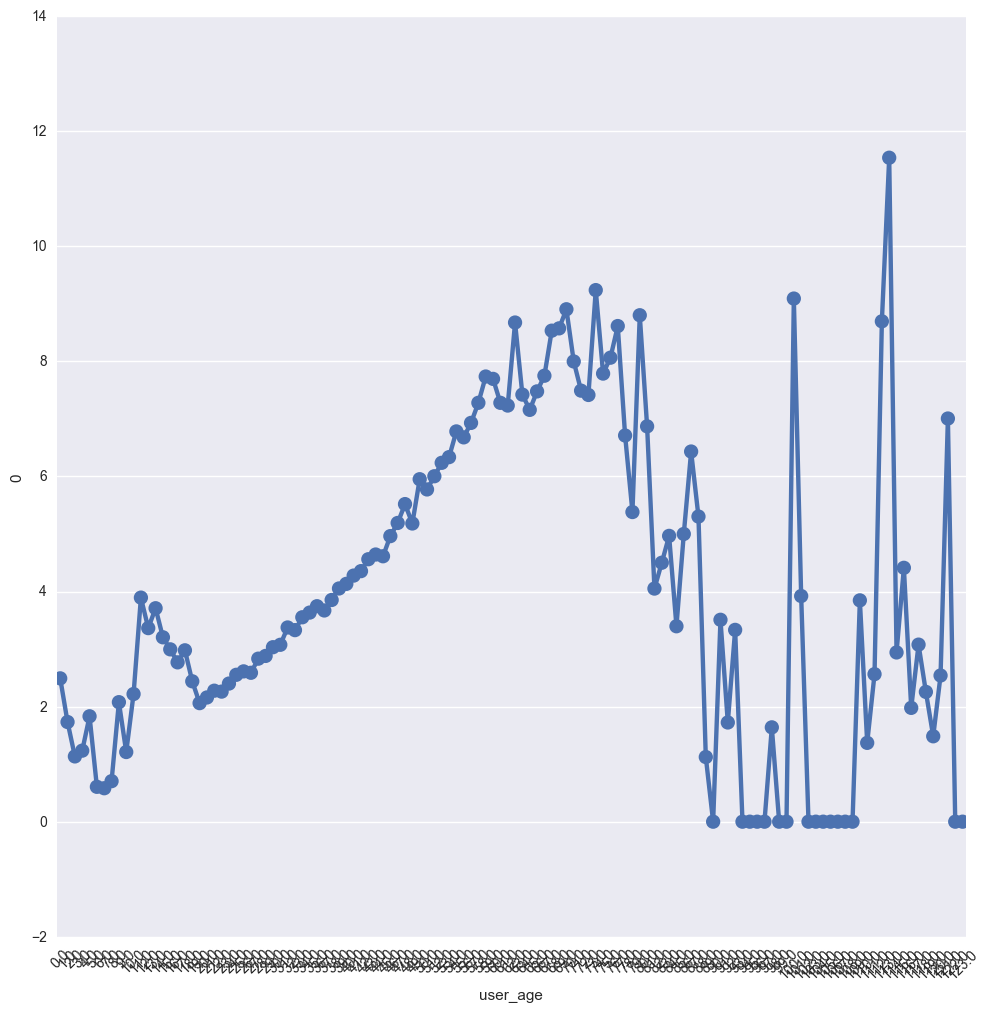

In [26]:
ax = sns.factorplot(data = age_agg_df, x='user_age', y =0, size = 10)
ax.set_xticklabels(rotation=45)

In [7]:
completion_rate_df_filtered = completion_rate_df.query('course_run_days>0').query('course_run_days<180')

In [8]:
completion_rate_df_filtered['completion_percentage']=completion_rate_df_filtered.completion_percentage.astype('float')

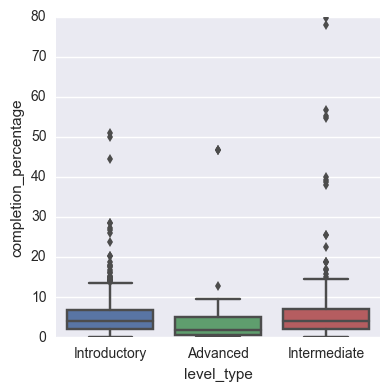

In [38]:
sns.factorplot(data= completion_rate_df_filtered, x="level_type", y="completion_percentage", kind = 'box')

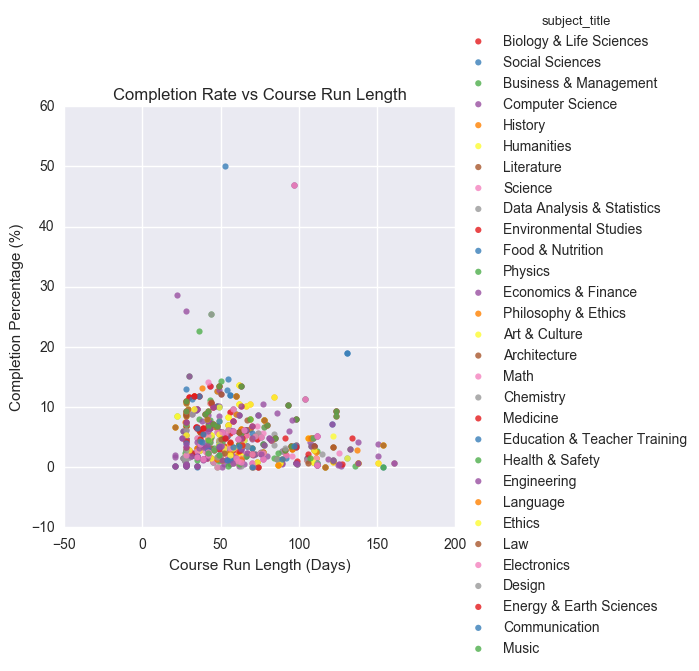

In [35]:
sns.lmplot(data = completion_rate_df_filtered, x = 'course_run_days', y = 'completion_percentage', hue='subject_title',
           fit_reg=False, palette="Set1"
          )
plt.title('Completion Rate vs Course Run Length')
plt.xlabel('Course Run Length (Days)')
plt.ylabel('Completion Percentage (%)')

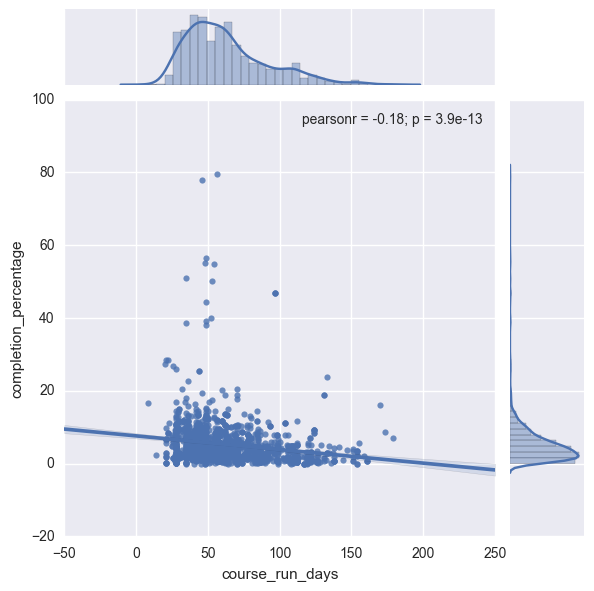

In [21]:
sns.jointplot(data = completion_rate_df_filtered, x="course_run_days", y="completion_percentage", kind="reg")


In [ ]:
sns.jointplot(data = completion_rate_df_filtered, x="course_run_days", y="completion_percentage", kind="reg")

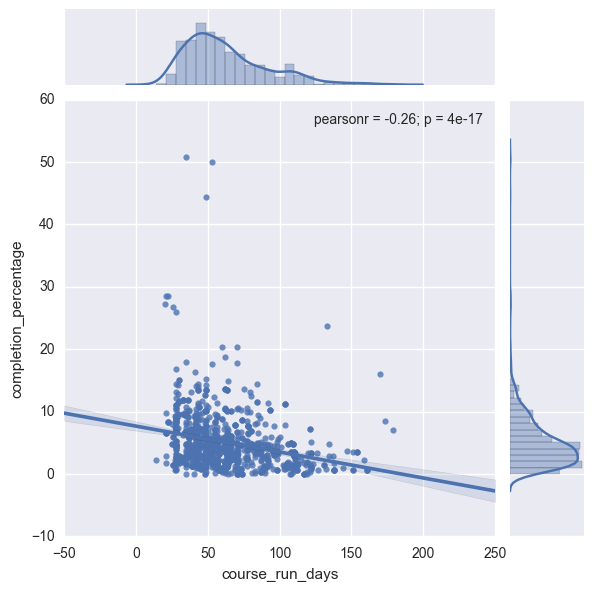

In [31]:
ax = sns.jointplot(data = completion_rate_df_filtered[completion_rate_df_filtered.level_type=='Introductory'], x="course_run_days", 
                    y="completion_percentage", kind="reg")

In [33]:
completion_rate_df_data = completion_rate_df_filtered[completion_rate_df_filtered['subject_title']=='Data Analysis & Statistics']

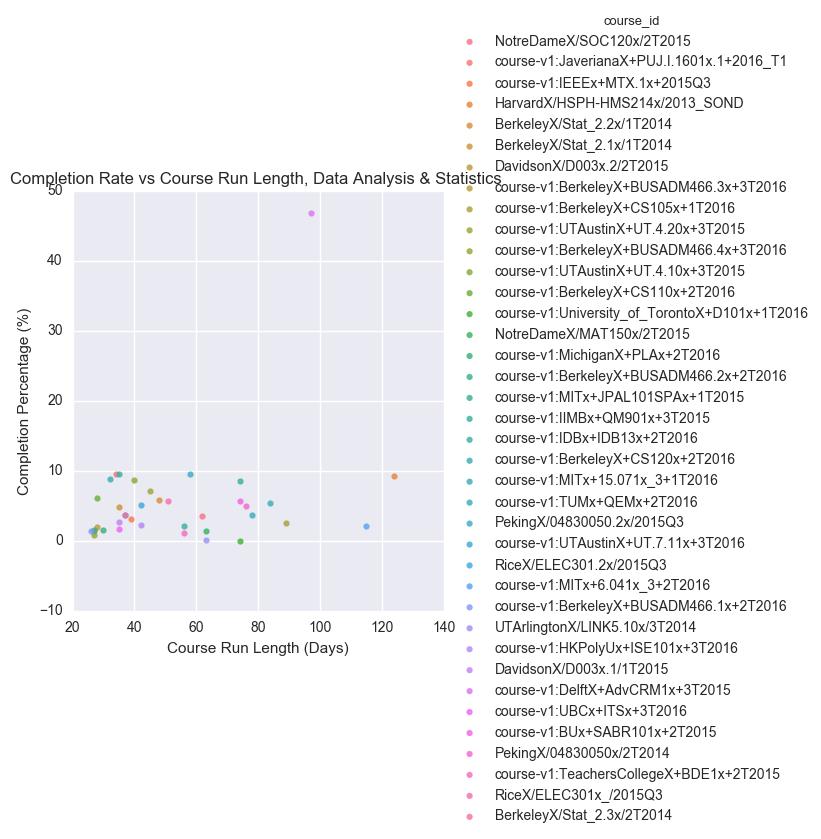

In [39]:
sns.lmplot(data = completion_rate_df_data, x = 'course_run_days', y = 'completion_percentage', fit_reg=False
          ,hue = 'course_id')
plt.title('Completion Rate vs Course Run Length, Data Analysis & Statistics ')
plt.xlabel('Course Run Length (Days)')
plt.ylabel('Completion Percentage (%)')